# Build Multimodal RAG with Amazon OpenSearch Service

In this notebook, you will build and run multimodal search using a sample retail dataset. You will use multimodal generated embeddings for text and image and experiment by running text search only, image search only and both text and image search in OpenSearch Service.

You will be using a retail dataset that contains 2,465 retail product samples that belong to different categories such as accessories, home decor, apparel, housewares, books, and instruments. Each product contains metadata including the ID, current stock, name, category, style, description, price, image URL, and gender affinity of the product. You will be using only the product image and product description fields in the solution.

 
Step 1: Create embeddings for text and images

Step 2: Store the embeddings in OpenSearch Service index

Step 3: Use LLM to generate text using the context from OpenSearch




---

Step 1: 

1. Build AI/connector between AOS and Embedding model - Titan Mulitmodal embeddings model
2. Register/Deploy the Embedding model in AOS
3. Create a KNN index in AOS
4. Create an ingest pipeline to generate the embedding inside AOS

Step 2:

1. Index the data

Step 3:

1. Run multimodal neural search query in AOS 
2. Feed the LLM with the extract results from AOS - Claude Sonnet 3 
2.1. Build AI/connector between AOS and LLM to generate the text
2.2. Register/Deploy the LLM in AOS
2.3. Run conversational search query in AOS (using the LLM model)

## 1. Lab Pre-requisites


For this notebook we require a few libraries. We'll use the Python clients for Amazon OpenSearch Service and Amazon Bedrock, and OpenSearch ML Client library for generating multimodal embeddings.

### 1.1. Import libraries & initialize resources
The line below will import all the relevant libraries and modules used in this notebook.

In [1]:
!pip install opensearch-py -q
!pip install opensearch_py_ml -q
!pip install deprecated -q
!pip install requests_aws4auth -q
print("Installs completed.")

Installs completed.


In [2]:
# Import Python libraries
import boto3
import json
from opensearchpy import OpenSearch, RequestsHttpConnection
# from opensearch_py_ml.ml_commons import MLCommonClient
import os
import urllib.request
import tarfile
# import requests 
from requests_aws4auth import AWS4Auth
from ruamel.yaml import YAML
from PIL import Image
import base64
import re

# Initiale variables for later use
embedding_connector_id = ""
embedding_model_id = ""
llm_connector_id = ""
llm_model_id = ""

print("Imports and initialization completed.")

Imports and initialization completed.


### 1.2. Get CloudFormation stack output variables

We have preconfigured a few resources by creating a CloudFormation stack in the account. Names and ARN of these resources will be used within this lab. We are going to load some of the information variables here.

In [3]:
# Create a Boto3 session
session = boto3.Session()

# Get the account id
account_id = boto3.client('sts').get_caller_identity().get('Account')

# Get the current region
region = session.region_name

cfn = boto3.client('cloudformation')

# Method to obtain output variables from Cloudformation stack. 
def get_cfn_outputs(stackname):
    outputs = {}
    for output in cfn.describe_stacks(StackName=stackname)['Stacks'][0]['Outputs']:
        outputs[output['OutputKey']] = output['OutputValue']
    return outputs

## Setup variables to use for the rest of the demo
cloudformation_stack_name = "multimodal-rag-opensearch"

outputs = get_cfn_outputs(cloudformation_stack_name)
aos_host = outputs['OpenSearchDomainEndpoint']
# s3_bucket = outputs['s3BucketTraining']
bedrock_inf_iam_role = outputs['BedrockBatchInferenceRole']
bedrock_inf_iam_role_arn = outputs['BedrockBatchInferenceRoleArn']
# sagemaker_notebook_url = outputs['SageMakerNotebookURL']
notebook_iam_role_arn = outputs['NotebookRoleArn']

# We will just print all the variables so you can easily copy if needed.
outputs

{'OpenSearchDashboardURL': 'https://search-opensearchservi-ti2tlbmagzwv-ltx5bdgye26ux24ef35hdhessi.us-west-2.es.amazonaws.com/_dashboards',
 'S3BucketSecureURL': 'https://multimodal-rag-opensearch-s3buckethosting-gpvzyttheqnt.s3.amazonaws.com',
 'SageMakerNotebookURL': 'https://console.aws.amazon.com/sagemaker/home?region=us-west-2#/notebook-instances/openNotebook/semantic-search-nb?view=classic',
 'OpenSearchDomainName': 'opensearchservi-ti2tlbmagzwv',
 'BedrockBatchInferenceRole': 'multimodal-rag-opensearch-AmazonBedrockBatchInferer-UhzLf5TeQ16C',
 'OpenSearchSecret': 'arn:aws:secretsmanager:us-west-2:568874691608:secret:OpenSearchSecret-multimodal-rag-opensearch-qeJO2B',
 'OpenSearchDomainEndpoint': 'search-opensearchservi-ti2tlbmagzwv-ltx5bdgye26ux24ef35hdhessi.us-west-2.es.amazonaws.com',
 'BedrockBatchInferenceRoleArn': 'arn:aws:iam::568874691608:role/multimodal-rag-opensearch-AmazonBedrockBatchInferer-UhzLf5TeQ16C',
 's3BucketTraining': 'multimodal-rag-opensearch-s3buckettrainin

### 1.3. Retrieve internal OpenSearch credentials (for this step only)

We have preconfigured a few resources by creating a CloudFormation stack in the account. Names and ARN of these resources will be used within this lab. We are going to load some of the information variables here.

In [4]:
# Connect to OpenSearch using the internal username and password obtained from AWS Secrets Manager
kms = boto3.client('secretsmanager')
aos_credentials = json.loads(kms.get_secret_value(SecretId=outputs['OpenSearchSecret'])['SecretString'])
auth = (

aos_credentials['username'], aos_credentials['password'])

# Create OpenSearch client
aos_client = OpenSearch(
    hosts=[f'https://{aos_host}'],
    http_auth=auth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection
)
aos_client

<OpenSearch([{'host': 'search-opensearchservi-ti2tlbmagzwv-ltx5bdgye26ux24ef35hdhessi.us-west-2.es.amazonaws.com', 'port': 443, 'use_ssl': True}])>

### 1.4 Map this Notebook's IAM role to OpenSearch backend role


In [5]:
# Define the role mapping to grant permissions to  AOS username and notebook_iam_role_arn
role_name = "all_access"

role_mapping = {
    "backend_roles": [notebook_iam_role_arn],
    "users" : [ aos_credentials['username'] ]
}

# Create the role mapping
response = aos_client.security.create_role_mapping(role=role_name, body=role_mapping)
print("Role mapping created:", response)

Role mapping created: {'status': 'OK', 'message': "'all_access' updated."}


### 1.5 Download the dataset to our Notebook instance

In [6]:
os.makedirs('tmp/images', exist_ok = True)
metadata_file = urllib.request.urlretrieve('https://aws-blogs-artifacts-public.s3.amazonaws.com/BDB-3144/products-data.yml', 'tmp/images/products.yaml')
img_filename,headers= urllib.request.urlretrieve('https://aws-blogs-artifacts-public.s3.amazonaws.com/BDB-3144/images.tar.gz', 'tmp/images/images.tar.gz')              
print(img_filename)
file = tarfile.open('tmp/images/images.tar.gz')
file.extractall('tmp/images/')
file.close()
#remove images.tar.gz
os.remove('tmp/images/images.tar.gz')
print("Data download and extraction completed.")

tmp/images/images.tar.gz
Data download and extraction completed.


## 2. Create, register, and deploy the OpenSearch Service ML connector to the Titan Multimodal Embeddings G1 model


#### NOTE: AUTHENTICATION CELL

At any point in this lab, if you get a failure message - The security token included in the request is expired. You can resolve it by running this cell again. The cell refreshes the security credentials that is required for the rest of the lab.

In [7]:
# Connect to OpenSearch using the IAM Role of this Jupyter notebook
# Create AWS4Auth instance
credentials = boto3.Session().get_credentials()
awsauth = AWS4Auth(
    credentials.access_key,
    credentials.secret_key,
    region,
    'es',
    session_token=credentials.token
)

# Create OpenSearch client
aos_client = OpenSearch(
    hosts=[f'https://{aos_host}'],
    http_auth=awsauth,
    use_ssl=True,
    verify_certs=True,
    connection_class=RequestsHttpConnection
)
print("Connection details: ")
aos_client

Connection details: 


<OpenSearch([{'host': 'search-opensearchservi-ti2tlbmagzwv-ltx5bdgye26ux24ef35hdhessi.us-west-2.es.amazonaws.com', 'port': 443, 'use_ssl': True}])>

### 2.1 Create the connnector

In [8]:
## Create an OpenSearch remote model connector with Amazon Bedrock Titan MM Embedding model.

if not embedding_connector_id:
    payload = {
        "name": "Amazon Bedrock Connector: embedding",
        "description": "The connector to bedrock Titan multimodal embedding model",
        "version": 1,
        "protocol": "aws_sigv4",
        "credential": {
          "roleArn": f"arn:aws:iam::{account_id}:role/{bedrock_inf_iam_role}"
           },
        "parameters": {
        "region": region,
        "service_name": "bedrock",
        "model": "amazon.titan-embed-image-v1"
            },
        "actions": [
            {
          "action_type": "predict",
          "method": "POST",
          "url": "https://bedrock-runtime.${parameters.region}.amazonaws.com/model/${parameters.model}/invoke",
          "headers": {
            "content-type": "application/json",
            "x-amz-content-sha256": "required"
              },
            "request_body": "{ \"inputText\": \"${parameters.inputText:-null}\", \"inputImage\": \"${parameters.inputImage:-null}\" }",
          "pre_process_function": "\n    StringBuilder parametersBuilder = new StringBuilder(\"{\");\n    if (params.text_docs.length > 0 && params.text_docs[0] != null) {\n      parametersBuilder.append(\"\\\"inputText\\\":\");\n      parametersBuilder.append(\"\\\"\");\n      parametersBuilder.append(params.text_docs[0]);\n      parametersBuilder.append(\"\\\"\");\n      \n      if (params.text_docs.length > 1 && params.text_docs[1] != null) {\n        parametersBuilder.append(\",\");\n      }\n    }\n    \n    \n    if (params.text_docs.length > 1 && params.text_docs[1] != null) {\n      parametersBuilder.append(\"\\\"inputImage\\\":\");\n      parametersBuilder.append(\"\\\"\");\n      parametersBuilder.append(params.text_docs[1]);\n      parametersBuilder.append(\"\\\"\");\n    }\n    parametersBuilder.append(\"}\");\n    \n    return  \"{\" +\"\\\"parameters\\\":\" + parametersBuilder + \"}\";",
          "post_process_function": "\n      def name = \"sentence_embedding\";\n      def dataType = \"FLOAT32\";\n      if (params.embedding == null || params.embedding.length == 0) {\n          return null;\n      }\n      def shape = [params.embedding.length];\n      def json = \"{\" +\n                 \"\\\"name\\\":\\\"\" + name + \"\\\",\" +\n                 \"\\\"data_type\\\":\\\"\" + dataType + \"\\\",\" +\n                 \"\\\"shape\\\":\" + shape + \",\" +\n                 \"\\\"data\\\":\" + params.embedding +\n                 \"}\";\n      return json;\n    "
                }
          ] 
        }

    response = aos_client.transport.perform_request(
        'POST',
        '/_plugins/_ml/connectors/_create',
        body=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )
    
    embedding_connector_id = response['connector_id']
else:
    print(f"Connector already exists - {embedding_connector_id}")
    
print("Embedding connector ID: " + embedding_connector_id)

Embedding connector ID: KBtfd5IBH-fJ1S1lNfG6


### 2.2 Register the model
Once the model connector is defined. We need to register the model and deploy. Following two cells will register and then deploy the model connection respectively.

In [9]:
# Register the multimodal embedding model
if not embedding_model_id:
    # Prepare the payload
    payload = {
        "name": "Bedrock Titan mm embeddings model",
        "function_name": "remote",
        "description": "Bedrock Titan mm embeddings model",
        "connector_id": embedding_connector_id
    }
    # Make the request
    response = aos_client.transport.perform_request(
        'POST',
        '/_plugins/_ml/models/_register',
        body=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )
    embedding_model_id = response['model_id']
else:
    print("skipping model registration - model already exists")
print("Model registered under model_id: "+embedding_model_id)

Model registered under model_id: Kxtfd5IBH-fJ1S1lSfGG


### 2.3 Deploy the connector and model

In [10]:
# Deploy the embedding model
response = aos_client.transport.perform_request(
    'POST',
    '/_plugins/_ml/models/'+embedding_model_id+'/_deploy',
    headers={"Content-Type": "application/json"}
)
print("Deployment status of the model, "+embedding_model_id+" : "+response['status'])

Deployment status of the model, Kxtfd5IBH-fJ1S1lSfGG : COMPLETED


### 2.4 Test the OpenSearch - Bedrock connector

In [11]:
img = "tmp/images/footwear/2d2d8ec8-4806-42a7-b8ba-ceb15c1c7e84.jpg"
with open(img, "rb") as image_file:
    input_image_binary = base64.b64encode(image_file.read()).decode("utf8")
    
payload = {
"parameters": {
"inputText": "Sleek, stylish black sneakers made for urban exploration. With fashionable looks and comfortable design, these sneakers keep your feet looking great while you walk the city streets in style",
"inputImage":input_image_binary
}
}

response = aos_client.transport.perform_request(
    'POST',
    '/_plugins/_ml/models/'+embedding_model_id+'/_predict',
    body=json.dumps(payload),
    headers={"Content-Type": "application/json"}
)

try:
    embed = response['inference_results'][0]['output'][0]['data'][0:10]
    shape = response['inference_results'][0]['output'][0]['shape'][0]
    print("Embedding test completed.")
    print("First 10 dimensions:")
    print(str(embed))
    print("\n")
    print("Total: " + str(shape) + " dimensions")
except KeyError as e:
    print(f"KeyError: {e}")
    print("The response does not contain the expected data structure.")
except Exception as e:
    print(f"Error: {e}")
    print("An unexpected error occurred.")

Embedding test completed.
First 10 dimensions:
[0.0025672666, 0.009171144, 0.012386386, -0.020567901, 0.008987624, 0.039484773, 0.051271744, 0.04154323, 0.0230735, -0.031851035]


Total: 1024 dimensions


## 3. Create the OpenSearch ingestion pipeline and index


Let's create an ingestion pipeline that will call Amazon Bedrock Titan Multimodal embedding model and convert the text and image into multimodal vector embedding. Ingest pipeline is a feature in OpenSearch that allows you to define certain actions to be performed at the time of data ingestion. You could do simple processing such as adding a static field, modify an existing field, or call a remote model to get inference and store inference output together with the indexed record/document. In our case inference output is vector embedding.

Following ingestion pipeline is going to call our remote model and convert product image `product_description` field and the `image_binary` to vector and store it in the field called `vector_embedding`

### 3.1 Create the ingestion pipeline

In [12]:
pipeline_id = "bedrock-multimodal-ingest-pipeline"
payload = {
    "description": "A text/image embedding pipeline",
    "processors": [
        {
            "text_image_embedding": {
                "model_id": embedding_model_id,
                "embedding": "vector_embedding",
                "field_map": {
                    "text": "product_description",
                    "image": "image_binary"
                }
            }
        }
    ]
}
response = aos_client.ingest.put_pipeline(id=pipeline_id, body=payload)
response

{'acknowledged': True}

### 3.2 Create the k-NN index

In [13]:
# Check if the index exists. Delete and recreate if it does. 
if aos_client.indices.exists(index='bedrock-multimodal-rag'):
    print("The index exists. Deleting...")
    response = aos_client.indices.delete(index='bedrock-multimodal-rag')
    
payload = {
  "settings": {
    "index.knn": True,
    "default_pipeline": "bedrock-multimodal-ingest-pipeline"
  },
  "mappings": {
      
    "_source": {
     
    },
    "properties": {
      "vector_embedding": {
        "type": "knn_vector",
        "dimension": shape,
        "method": {
          "name": "hnsw",
          "engine": "faiss",
          "parameters": {}
        }
      },
      "product_description": {
        "type": "text"
      },
        "image_url": {
        "type": "text"
      },
      "image_binary": {
        "type": "binary"
      }
    }
  }
}

print("Creating index...")
response = aos_client.indices.create(index='bedrock-multimodal-rag',body=payload)
response

Creating index...


{'acknowledged': True,
 'shards_acknowledged': True,
 'index': 'bedrock-multimodal-rag'}

### 3.3 Index the dataset to the index

In [14]:
def resize_image(photo, width, height):
    Image.MAX_IMAGE_PIXELS = 100000000
    
    with Image.open(photo) as image:
        image.verify()
    with Image.open(photo) as image:    
        
        if image.format in ["JPEG", "PNG"]:
            file_type = image.format.lower()
            path = image.filename.rsplit(".", 1)[0]

            image.thumbnail((width, height))
            image.save(f"{path}-resized.{file_type}")
    return file_type, path

# Load the products from the dataset
yaml = YAML()
items_ = yaml.load(open('tmp/images/products.yaml'))

batch = 0
count = 0
body_ = ''
batch_size = 100
last_batch = int(len(items_)/batch_size)
action = json.dumps({ 'index': { '_index': 'bedrock-multimodal-rag' } })

for item in items_:
    count+=1
    fileshort = "tmp/images/"+item["category"]+"/"+item["image"]
    payload = {}
    payload['image_url'] = fileshort
    payload['product_description'] = item['description']
    
    #resize the image and generate image binary
    file_type, path = resize_image(fileshort, 2048, 2048)

    with open(fileshort.split(".")[0]+"-resized."+file_type, "rb") as image_file:
        input_image = base64.b64encode(image_file.read()).decode("utf8")
    
    os.remove(fileshort.split(".")[0]+"-resized."+file_type)
    payload['image_binary'] = input_image
    
    body_ = body_ + action + "\n" + json.dumps(payload) + "\n"
    
    if(count == batch_size): # When count reaches batch size, send to bulk for indexing.
        response = aos_client.bulk(
        index = "bedrock-multimodal-rag",
        body = body_
        )
        batch += 1
        count = 0
        print("batch "+str(batch) + " ingestion done!")
        if(batch != last_batch):
            body_ = ""
        
            
#ingest the remaining rows
response = aos_client.bulk(
        index = "bedrock-multimodal-rag",
        body = body_
        )
        
print("All "+str(last_batch)+" batches ingested into index")

batch 1 ingestion done!
batch 2 ingestion done!
batch 3 ingestion done!
batch 4 ingestion done!
batch 5 ingestion done!
batch 6 ingestion done!
batch 7 ingestion done!
batch 8 ingestion done!
batch 9 ingestion done!
batch 10 ingestion done!
batch 11 ingestion done!
batch 12 ingestion done!
batch 13 ingestion done!
batch 14 ingestion done!
batch 15 ingestion done!
batch 16 ingestion done!
batch 17 ingestion done!
batch 18 ingestion done!
batch 19 ingestion done!
batch 20 ingestion done!
batch 21 ingestion done!
batch 22 ingestion done!
batch 23 ingestion done!
batch 24 ingestion done!
All 24 batches ingested into index


### 3.4 Check indexing by running an OpenSearch query: 

In [15]:
res = aos_client.search(index="bedrock-multimodal-rag", body={"query": {"match_all": {}}})
print("Records found: %d." % res['hits']['total']['value'])

Records found: 2499.


## 4. Lexical and vector search

### 4.1 Lexical search
Try using different keywords and phrases to see different results.
Replace the `query` string with your search and then run the code block.

1. Elevate your style with these elegant white leather formal shoes. Crafted from smooth genuine leather with a sleek and sophisticated design, these versatile shoes offer sophistication and comfort for work or special events.


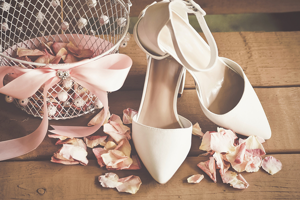


2. Introducing the Rosy-Brown Brogue Leather Formal Shoes - a sophisticated pair of rosy-brown leather lace-up shoes for men. Expertly crafted with quality leather and intricate brogue detailing, these versatile formal shoes provide durability, comfort, and polished style for any occasion.


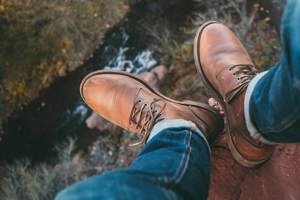


3. Make an elegant entrance in these rich crimson formal shoes. With a modest heel and durable leather finish, these versatile shoes offer timeless beauty and unmatched comfort so you can dance the night away in style.


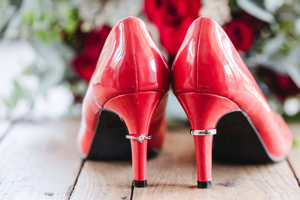


4. Expertly crafted black leather lace-up dress shoes offering timeless style and sophistication. The sleek formal design and durable leather construction make these versatile shoes perfect for both work and formal events.


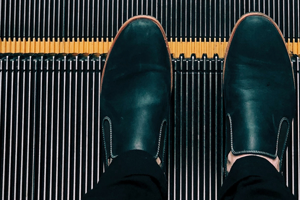


5. Make a polished impression with these classic brown leather oxford shoes. Crafted from premium materials, these sleek lace-up shoes offer timeless style and long-lasting comfort for the modern businessman.


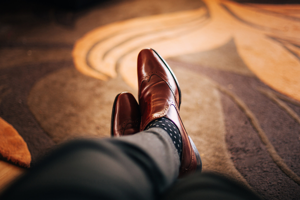

In [16]:
# Lexical search: Using query text only
query = "shoes"
index_name = "bedrock-multimodal-rag"
search_body = {
    "_source": {
        "exclude": ["vector_embedding"]
    },
    "query": {
        "match": {
            "product_description": {
                "query": query
            }
        }
    },
    "size": 5
}

# Perform the search
response = aos_client.search(
    body=search_body,
    index=index_name
)

#Output the results
count = 1
for hit in response['hits']['hits']:
    print(str(count) + ". " + hit["_source"]["product_description"])
    image = Image.open(hit["_source"]["image_url"])
    new_size = (300, 200)
    resized_img = image.resize(new_size)
    resized_img.show()
    count+=1
    print('')

### 4.2 Vector search with both image and text as inputs

Input text query: travel
Input query Image:


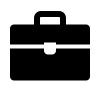

Search results:
1. The Black Travel Backpack from Acme is a versatile, durable, and spacious accessory perfect for keeping essentials organized on the go. Its minimalist black design pairs easily with any outfit while the padded straps provide comfortable carrying.


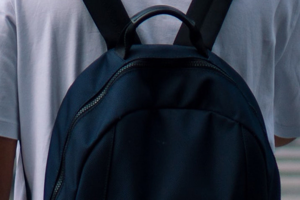


2. This leather bag blends timeless style and handy organization. Designed with multiple pockets and a roomy interior, it keeps essentials in order while complementing any outfit.


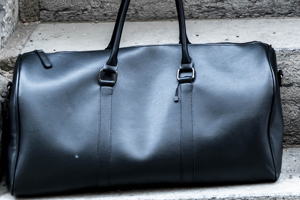


3. Expertly crafted from fine leather, this versatile crossbody bag keeps you organized with handy compartments while lending sophisticated style to your look. Durable and timeless, it's the perfect accessory for work and travel.


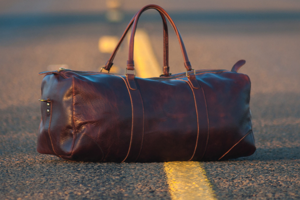


4. The Sienna everyday bag is a versatile, lightweight accessory with ample storage to keep essentials organized. Crafted with premium materials, it transitions seamlessly from work to weekend with its sleek, compact design and adjustable strap.


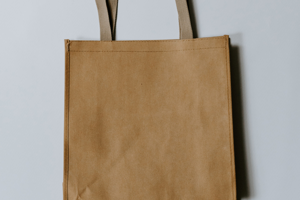


5. The Canvas Everyday Bag is a versatile and practical canvas accessory with ample storage to carry your daily essentials in classic style.


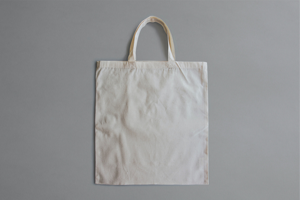

In [19]:
# Multimodal Search using text and image as inputs
query_text = "travel"
query_image = "./simple_bag.jpg"

img = Image.open(query_image) 
print("Input text query: "+query_text)
print("Input query Image:")
img.show()

# Define the query and search body
with open(query_image, "rb") as image_file:
    query_image_binary = base64.b64encode(image_file.read()).decode("utf8")
search_body = {
    "_source": {
        "exclude": [
            "vector_embedding"
        ]
        },
        "query": {    
            "neural": {
                "vector_embedding": {           
                    "query_image":query_image_binary,
                    "query_text":query_text,     
                    "model_id": embedding_model_id,
                    "k": 5
                }
            }
        },
        "size":5
      }

# Perform the search
response = aos_client.search(
    body=search_body,
    index=index_name
)

#Output the results
print('Search results:')
count = 1
for hit in response['hits']['hits']:
    print(str(count) + ". " + hit["_source"]["product_description"])
    image = Image.open(hit["_source"]["image_url"])
    new_size = (300, 200)
    resized_img = image.resize(new_size)
    resized_img.show()
    count+=1
    print('')

## 5. Multimodal conversational search

Conversational search lets you ask questions in natural language, receive a text response based on a provided context, and ask additional  questions with context.

In this section, you will be using OpenSearch Service as the knowledge database to run multimodal retrieval and augment the LLM prompt with the relevant context. You will be using Claude v2 Sonnet as the foundational model to generate responses and provide fashion advice to end users based on the available retail items stored in OpenSearch Service.


### 5.1 Create an OpenSearch Bedrock Claude LLM connector


In [20]:
if not llm_connector_id:
    connector_payload = {
        "name": "Amazon Bedrock Connector: Claude 2",
        "description": "The connector to bedrock Claude V2",
        "version": 1,
        "protocol": "aws_sigv4",
        "credential": {
            "roleArn": f"arn:aws:iam::{account_id}:role/{bedrock_inf_iam_role}"
        },
        "parameters": {
            "region": region,
            "service_name": "bedrock",
            "auth": "Sig_V4",
            "model": "anthropic.claude-v2"
        },
        "actions": [
            {
                "action_type": "predict",
                "method": "POST",
                "headers": {
                    "content-type": "application/json"
                },
                "url": "https://bedrock-runtime.${parameters.region}.amazonaws.com/model/${parameters.model}/invoke",
                "request_body": "{\"prompt\":\"\\n\\nHuman: ${parameters.inputs}\\n\\nAssistant:\",\"max_tokens_to_sample\":300,\"temperature\":0.5,\"top_k\":250,\"top_p\":1,\"stop_sequences\":[\"\\\\n\\\\nHuman:\"]}"
            }
        ]
    }
    
    # Create the connector
    response = aos_client.transport.perform_request(
        'POST',
        '/_plugins/_ml/connectors/_create',
        body=connector_payload
    )
    # Print the response
    llm_connector_id = response['connector_id']
else:
    print(f"Connector already exists")
    
print("LLM connector ID: " + llm_connector_id)

LLM connector ID: 8Btid5IBH-fJ1S1lg_r8


### 5.2 Register and deploy the Claude LLM connector

In [21]:
# Register and deploy the llm model
if not llm_model_id:
    payload = { 
        "name": "Amazon Bedrock Connector: Claude v2",
        "function_name": "remote",
        "description": "The connector to bedrock Claude v2",
        "connector_id": llm_connector_id
    }
    # Make the request
    response = aos_client.transport.perform_request(
        'POST',
        '/_plugins/_ml/models/_register',
        body=json.dumps(payload),
        headers={"Content-Type": "application/json"}
    )
    llm_model_id = response['model_id']
# Display the response    
response

{'task_id': '8htid5IBH-fJ1S1lkfpK',
 'status': 'CREATED',
 'model_id': '8xtid5IBH-fJ1S1lkfpd'}

### 5.3 Test the LLM connector by running an inference 
We will run the test inference without searching the index by passing an input directly to the LLM connector we just deployed.

In [22]:
# Prepare the query string
payload = {
    "parameters": {
        "inputs": "What are the most important features of a travel bag? Be concise."
    }
}
# Make the request
response = aos_client.transport.perform_request(
    'POST',
    '/_plugins/_ml/models/'+llm_model_id+'/_predict',
    body=payload,
    headers={"Content-Type": "application/json"}
)
# Check the response 
if response['inference_results'][0]['status_code'] == 200:
    llm_gen = response['inference_results'][0]['output'][0]['dataAsMap']['completion']
    print(str("Claude generated response without context: \n\n"+llm_gen))

Claude generated response without context: 

 Here are 5 key features to look for in a travel bag:

- Durability - made with sturdy, abrasion-resistant materials
- Comfort - well-padded straps and back panel 
- Organization - plenty of pockets and compartments  
- Capacity - roomy enough for all your essentials
- Portability - lightweight and easy to transport


### 5.4 Enable the memory and rag pipeline features of OpenSearch

In [23]:
# Set plugin settings using the cluster.put_settings method of the OpenSearch client
response = aos_client.cluster.put_settings(
    body={
        "persistent": {
            "plugins.ml_commons.memory_feature_enabled": "true",
            "plugins.ml_commons.rag_pipeline_feature_enabled": "true"
        }
    }
)
# Print response. Look for 'acknowledged': True
response

{'acknowledged': True,
 'persistent': {'plugins': {'ml_commons': {'memory_feature_enabled': 'true',
    'rag_pipeline_feature_enabled': 'true'}}},
 'transient': {}}

### 5.5 Create a search pipeline (shopping assistant)
In order to have a conversational search, the LLM needs to remember the context of the entire conversation to have follow-up questions. This is composed of two components:
- Conversational memory to provide the history context
- Retrieval-augmented generation (RAG) pipeline to provide the search context

The retrieval_augmented_generation processor, part of the RAG pipeline, is a search results processor that intercepts query results, retrieves previous messages from the conversation, and sends a prompt to a large language model (LLM), saving the response in conversational memory and returning both the original OpenSearch query results and the LLM response.

Let's create the search pipeline with the retrieval_augmented_generation processor to use at search time.

In [24]:
# Prepare the response processor attributes
payload = {
    "response_processors": [
    {
      "retrieval_augmented_generation": {
        "tag": "bedrock_rag-pipeline_demo",
        "description": "Search pipeline using Bedrock Claude v2 Connector for RAG",
        "model_id": llm_model_id,
        "context_field_list": ["product_description"],
        "system_prompt": "You are a helpful shopping advisor that uses their vast knowledge of fashion tips to make great recommendations people will enjoy.",
        "user_instructions": "As a shopping advisor, be friendly and approachable. Greet the customer warmly. Evaluate each item provided in the context and provide a concise recommendation about each item to matches best the customer question using the order and number of search result related to each item. If there are items in the provided context that do not match the user question, explain that this may be due to insufficient items in the inventory. Finally, thank the client and let them know you're available if they have any other questions."
      }
    }
  ]
}
# Make the request
response = aos_client.transport.perform_request(
    'PUT',
    "/_search/pipeline/multimodal_rag_pipeline",
    body=payload,
    headers={"Content-Type": "application/json"}
)
# Print response. Look for 'acknowledged': True
response

{'acknowledged': True}

### 5.6 Create a conversational memory object

#### NOTE: Re-run the below cell to create a new memory ID

In [25]:
# Prepare the query string
payload = {
    
    "name": "Conversation about products"
}
# Make the request
response = aos_client.transport.perform_request(
    'POST',
    "/_plugins/_ml/memory/",
    body=payload,
    headers={"Content-Type": "application/json"}
)
# Persist memory_id
memory_id = response['memory_id']
# Print the 'memory_id'
print("The new memory id is: " +memory_id) 

The new memory id is: 9Rtjd5IBH-fJ1S1l6_qJ


### 5.7 Start a conversational search

Input text query: for a long trip.
Input query Image:


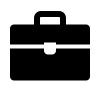

Search results and Shopping assistant recommendations:
Search result 1: 
The Black Travel Backpack from Acme is a versatile, durable, and spacious accessory perfect for keeping essentials organized on the go. Its minimalist black design pairs easily with any outfit while the padded straps provide comfortable carrying.


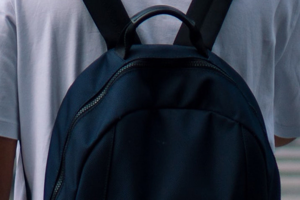


Search result 2: 
Expertly crafted from fine leather, this versatile crossbody bag keeps you organized with handy compartments while lending sophisticated style to your look. Durable and timeless, it's the perfect accessory for work and travel.


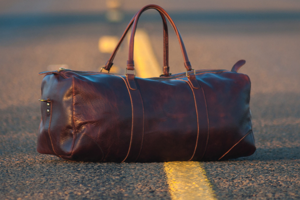


Search result 3: 
This leather bag blends timeless style and handy organization. Designed with multiple pockets and a roomy interior, it keeps essentials in order while complementing any outfit.


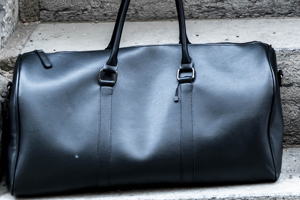


Search result 4: 
The Sienna everyday bag is a versatile, lightweight accessory with ample storage to keep essentials organized. Crafted with premium materials, it transitions seamlessly from work to weekend with its sleek, compact design and adjustable strap.


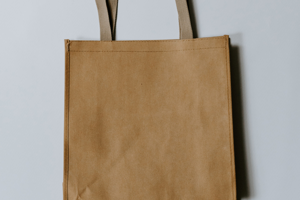


Search result 5: 
Expertly crafted black button-down shirt made from soft, breathable fabric. Stylish and versatile for both casual and smart looks. The regular fit flatters most body types while the crisp, wrinkle-resistant material keeps you looking sharp.


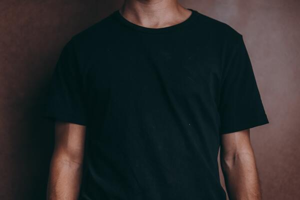


Shopping assistant: 
[]


In [26]:
# RAG using multimoadal search to provide prompt context
# Text and image as inputs
query_text = "for a long trip."
query_image = "./simple_bag.jpg"

img = Image.open(query_image) 
print("Input text query: "+query_text)
print("Input query Image:")
img.show()

# Define the query and search body
with open(query_image, "rb") as image_file:
    query_image_binary = base64.b64encode(image_file.read()).decode("utf8")

response = aos_client.search(
    index='bedrock-multimodal-rag',
    body={
        "_source": {
            "exclude": ["vector_embedding", "image_binary"]
        },
        "query": {
            "neural": {
                "vector_embedding": {
                    "query_image": query_image_binary,
                    "query_text": query_text,
                    "model_id": embedding_model_id,
                    "k": 5
                }
            }
        },
        "size": 5,
        "ext": {
            "generative_qa_parameters": {
                "llm_model": "bedrock/claude",
                "llm_question": query_text,
                "memory_id": memory_id,
                "context_size": 5,
                "message_size": 5,
                "timeout": 60
            }
        }
    },
    params={
        "search_pipeline": "multimodal_rag_pipeline"
    },
    request_timeout=30
)
# Extract the generated 'shopping assistant' recommendations
# Split the string into lines
# lines = response['ext']['retrieval_augmented_generation']['answer'].split('\n')
recommendations = response['ext']['retrieval_augmented_generation']['answer']
# for line in lines:
#     if re.match(r'[^\s\0]+', line):
#         recommendations.append(line.strip())
    
# Output the search results and shopping assistnat recommendations together
print('Search results and Shopping assistant recommendations:')
count = 1
for hit in response['hits']['hits']:
    print("Search result "+str(count) + ": ")
    print(hit["_source"]["product_description"])
    # print("Shopping assistant: ")
    # print(recommendations[count-1])
    image = Image.open(hit["_source"]["image_url"])
    new_size = (300, 200)
    resized_img = image.resize(new_size)
    resized_img.show()
    count+=1
    print('')
print("Shopping assistant: ")
print(recommendations)

### 5.8 Ask a follow up question

Input text query: thanks. What is likely to be best for air travel?
Search results and Shopping assistant recommendations:
Search result 1: 
The Black Travel Backpack from Acme is a versatile, durable, and spacious accessory perfect for keeping essentials organized on the go. Its minimalist black design pairs easily with any outfit while the padded straps provide comfortable carrying.


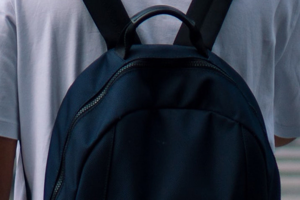


Search result 2: 
Expertly crafted from fine leather, this versatile crossbody bag keeps you organized with handy compartments while lending sophisticated style to your look. Durable and timeless, it's the perfect accessory for work and travel.


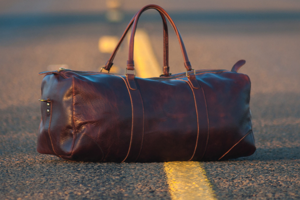


Search result 3: 
Style and comfort meet in these lightweight men's sandals featuring a contoured footbed and durable straps. The breathable design keeps feet cool while the hip styling adds fashionable flair for casual summer wear.


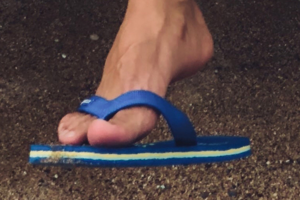


Search result 4: 
This versatile orange bag for men keeps belongings organized with multiple pockets while adding a stylish pop of color to any outfit. Expertly crafted from durable materials, it's the perfect accessory for work, travel, or everyday adventures.


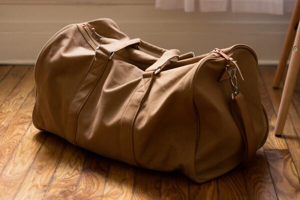


Search result 5: 
Comfortable, stylish socks crafted with soft, breathable materials in various colors and patterns. Perfect for any occasion, these high-quality dress socks offer a comfortable fit and versatile style for work or weekends.


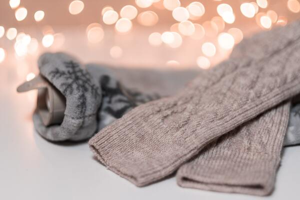


Shopping assistant: 
 Based on your question about items for air travel, I would recommend the Black Travel Backpack from the first search result. Here are a few reasons why:

- It's spacious and has plenty of room for packing clothes, toiletries, electronics, and other travel essentials. The extra storage capacity is useful for longer trips.

- The backpack format makes it easy to carry through airports and navigate tight spaces like airplane aisles. Hands-free carrying is convenient when traveling.

- Padded straps help distribute weight and make the backpack comfortable to wear, even when loaded down. This is great for long days traveling.

- The durable and water-resistant materials protect belongings from splashes or light rain during airport transfers. It should hold up well to the wear-and-tear of travel.

- The minimalist black design gives it a classy look that won't stand out too much or look too casual. It's appropriate for most situations.

The crossbody bag from the secon

In [30]:
query_text = "thanks. What is likely to be best for air travel?"

print("Input text query: " + query_text)

# Perform the search (no new image this time)
response = aos_client.search(
    index='bedrock-multimodal-rag',
    body={
        "_source": {
            "exclude": ["vector_embedding", "image_binary"]
        },
        "query": {
            "neural": {
                "vector_embedding": {
                    #"query_image": query_image_binary, (leaving out the image for now)
                    "query_text": query_text,
                    "model_id": embedding_model_id,
                    "k": 5
                }
            }
        },
        "size": 5,
        "ext": {
            "generative_qa_parameters": {
                "llm_model": "bedrock/claude",
                "llm_question": query_text,
                "memory_id": memory_id,
                "context_size": 5,
                "message_size": 5,
                "timeout": 60
            }
        }
    },
    params={
        "search_pipeline": "multimodal_rag_pipeline"
    },
    request_timeout=30
)
# Extract the recommendations from the response
# Split the string into lines
# lines = response['ext']['retrieval_augmented_generation']['answer'].split('\n')
recommendations = response['ext']['retrieval_augmented_generation']['answer']
# for line in lines:
#     if re.match(r'[^\s\0]+', line):
#         recommendations.append(line.strip())
# Output the search results and shopping assistnat recommendations together
print('Search results and Shopping assistant recommendations:')
count = 1
for hit in response['hits']['hits']:
    print("Search result "+str(count) + ": ")
    print(hit["_source"]["product_description"])
    # print("Shopping assistant: ")
    # print(recommendations[count-1])
    image = Image.open(hit["_source"]["image_url"])
    new_size = (300, 200)
    resized_img = image.resize(new_size)
    resized_img.show()
    count+=1
    print('')
print("Shopping assistant: ")
print(recommendations)

### 5.9 Check the conversation history

To verify that the messages were added to the memory, provide the memory_ID to the Get Messages API:

In [31]:
# Make the request
response = aos_client.transport.perform_request(
    'GET',
    "/_plugins/_ml/memory/"+memory_id +'/messages',
    headers={"Content-Type": "application/json"}
)
# Print the response. You should see a dictionary containing a list of messages.
#print(response) 
for message in response['messages']:
    print(message)

{'memory_id': '9Rtjd5IBH-fJ1S1l6_qJ', 'message_id': '9htkd5IBH-fJ1S1lhPo-', 'create_time': '2024-10-10T17:05:29.077626888Z', 'input': 'for a long trip.', 'prompt_template': '[{"role":"system","content":"You are a helpful shopping advisor that uses their vast knowledge of fashion tips to make great recommendations people will enjoy."},{"role":"user","content":"As a shopping advisor, be friendly and approachable. Greet the customer warmly. Evaluate each item provided in the context and provide a concise recommendation about each item to matches best the customer question using the order and number of search result related to each item. If there are items in the provided context that do not match the user question, explain that this may be due to insufficient items in the inventory. Finally, thank the client and let them know you\'re available if they have any other questions."}]', 'response': " Hello there! Thank you for coming to me for fashion advice. Based on your question about items

# Bonus: Deploy your web application

To deploy this code as an application we will use [Streamlit](https://streamlit.io/). 

**Step 1:** Export the connector and model IDs you created earlier in this notebook. We will store them to a file so that they can be referenced outside of the notebook and persisted between kernel restarts.

In [32]:
connector_ids = {}
connector_ids['llm_connector_id'] = llm_connector_id
connector_ids['llm_model_id'] = llm_model_id
connector_ids['embedding_connector_id'] = embedding_connector_id
connector_ids['embedding_model_id'] = embedding_model_id
connector_ids['aos_host'] = aos_host

with open('connector_ids.json', 'w') as file:
    json.dump(connector_ids, file)

**Step 2:** Since you will launch the app.py script using the Notebook instance's shell, you need to install the package libraries in the shell environment.

In [33]:
!pip install streamlit

  Using cached GitPython-3.1.43-py3-none-any.whl.metadata (13 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.5 MB/s eta 0:00:00
  Using cached gitdb-4.0.11-py3-none-any.whl.metadata (1.2 kB)
  Using cached smmap-5.0.1-py3-none-any.whl.metadata (4.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 85.9 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 73.6 MB/s eta 0:00:00
Using cached GitPython-3.1.43-py3-none-any.whl (207 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 150.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 kB 16.0 MB/s eta 0:00:00
Using cached gitdb-4.0.11-py3-none-any.whl (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.1/185.1 kB 34.6 MB/s eta 0:00:00
Using cached smmap-5.0.1-py3-none-any.whl (24 kB)


**Step 3:** Run the streamlit application from the shell. 
<br> The '--server.baseUrlPath' argument is used to set a custom base URL for the Streamlit app.

In [ ]:
!streamlit run app4.py --server.baseUrlPath="/proxy/absolute/8501"




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501/proxy/absolute/8501
  Network URL: http://172.16.70.144:8501/proxy/absolute/8501
  External URL: http://52.42.79.222:8501/proxy/absolute/8501

Input text query: Looking for a travel bag.
Input query Image:
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=96x96 at 0x7F049C46A4A0>


Access the app at this URL: https://semantic-search-nb-qnru.notebook.us-east-1.sagemaker.aws/proxy/absolute/8501/

Update the above URL with the host name of your Jupyter notebook.